In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from dataset_builder.actor_splitting import build_dataset_from_actors
from cnn_model.model_validation import stratified_80_10_10_split, print_split_stats
from cnn_model.model import CNN_GAP   # or CNN_MaxPool
from cnn_model.model_evaluation import evaluate_model


In [ ]:
DATASET_DIR = "../data/ravdess"
ALL_ACTORS = list(range(1, 25))

X_all, y_all, genders_all = build_dataset_from_actors(DATASET_DIR, ALL_ACTORS,augment=True)


Building dataset: 100%|█████████████████████████████████████████████| 24/24 [00:34<00:00,  1.42s/it]


In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = stratified_80_10_10_split(X_all, y_all)
print_split_stats(y_train, y_val, y_test)


Train distribution: Counter({np.str_('disgust'): 154, np.str_('angry'): 154, np.str_('sad'): 154, np.str_('calm'): 154, np.str_('happy'): 153, np.str_('surprised'): 153, np.str_('fearful'): 153, np.str_('neutral'): 77})
Val distribution: Counter({np.str_('surprised'): 20, np.str_('happy'): 20, np.str_('disgust'): 19, np.str_('angry'): 19, np.str_('fearful'): 19, np.str_('sad'): 19, np.str_('calm'): 19, np.str_('neutral'): 9})
Test distribution: Counter({np.str_('fearful'): 20, np.str_('calm'): 19, np.str_('happy'): 19, np.str_('angry'): 19, np.str_('sad'): 19, np.str_('disgust'): 19, np.str_('surprised'): 19, np.str_('neutral'): 10})


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

emotion_labels = label_encoder.classes_
print("Classes:", label_encoder.classes_)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [6]:
X_train_t = torch.tensor(X_train).unsqueeze(1).float()
y_train_t = torch.tensor(y_train_enc).long()

X_test_t = torch.tensor(X_test).unsqueeze(1).float()
y_test_t = torch.tensor(y_test_enc).long()


In [7]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,      # safe for CPU
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)


In [8]:
model = CNN_GAP(num_classes=8)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [9]:
for epoch in range(15):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    


Epoch 1 | Loss: 2.0014
Epoch 2 | Loss: 1.9241
Epoch 3 | Loss: 1.8643
Epoch 4 | Loss: 1.8319
Epoch 5 | Loss: 1.8034
Epoch 6 | Loss: 1.7857
Epoch 7 | Loss: 1.7585
Epoch 8 | Loss: 1.7404
Epoch 9 | Loss: 1.7376
Epoch 10 | Loss: 1.7184
Epoch 11 | Loss: 1.7142
Epoch 12 | Loss: 1.7515
Epoch 13 | Loss: 1.7082
Epoch 14 | Loss: 1.6891
Epoch 15 | Loss: 1.6729


In [10]:
genders_test = genders_all[len(X_train) + len(X_val):]
cm = evaluate_model(
    model,
    X_test_t,
    y_test_t,
    genders_test
)


Test Accuracy   : 0.3333
Test Macro F1   : 0.2871
Male Macro F1   : 0.2847
Female Macro F1 : 0.2809


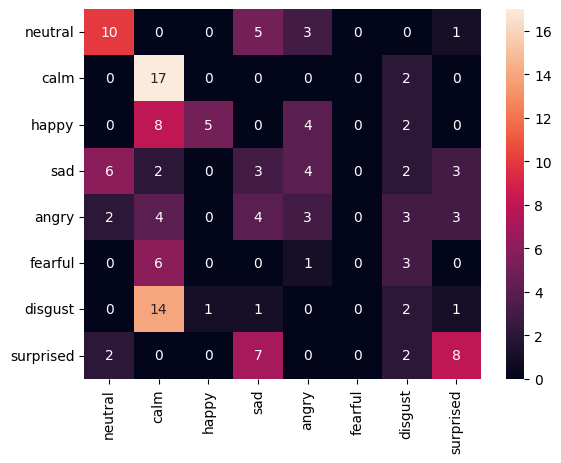

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
emotion_labels = [
    "neutral", "calm", "happy", "sad",
    "angry", "fearful", "disgust", "surprised"
]

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.show()
